In [1]:
import nmp_util
from nmp_util import *

In [2]:
r_sym, phi_sym = sympy.symbols('r, phi')

# expression for the variable transformation f
f_expr = sympy.Matrix([
    r_sym*sympy.cos(phi_sym), 
    r_sym*sympy.sin(phi_sym)
])


formula, K = nmp_util.error_propagation_formula(f_expr,[r_sym,phi_sym])

display(formula, sympy.latex(formula))

k11, k22 = sympy.symbols('k11, k22')
diagonal_k = sympy.diag([k11,k22], unpack=True)

#doit is necessary to perform matmul
formula = formula.subs({K:diagonal_k}).doit() 

display(formula, sympy.latex(formula))

Matrix([
[cos(phi), -r*sin(phi)],
[sin(phi),  r*cos(phi)]])*K*Matrix([
[   cos(phi),   sin(phi)],
[-r*sin(phi), r*cos(phi)]])

'\\left[\\begin{matrix}\\cos{\\left(\\phi \\right)} & - r \\sin{\\left(\\phi \\right)}\\\\\\sin{\\left(\\phi \\right)} & r \\cos{\\left(\\phi \\right)}\\end{matrix}\\right] K \\left[\\begin{matrix}\\cos{\\left(\\phi \\right)} & \\sin{\\left(\\phi \\right)}\\\\- r \\sin{\\left(\\phi \\right)} & r \\cos{\\left(\\phi \\right)}\\end{matrix}\\right]'

Matrix([
[            k11*cos(phi)**2 + k22*r**2*sin(phi)**2, k11*sin(phi)*cos(phi) - k22*r**2*sin(phi)*cos(phi)],
[k11*sin(phi)*cos(phi) - k22*r**2*sin(phi)*cos(phi),             k11*sin(phi)**2 + k22*r**2*cos(phi)**2]])

'\\left[\\begin{matrix}k_{11} \\cos^{2}{\\left(\\phi \\right)} + k_{22} r^{2} \\sin^{2}{\\left(\\phi \\right)} & k_{11} \\sin{\\left(\\phi \\right)} \\cos{\\left(\\phi \\right)} - k_{22} r^{2} \\sin{\\left(\\phi \\right)} \\cos{\\left(\\phi \\right)}\\\\k_{11} \\sin{\\left(\\phi \\right)} \\cos{\\left(\\phi \\right)} - k_{22} r^{2} \\sin{\\left(\\phi \\right)} \\cos{\\left(\\phi \\right)} & k_{11} \\sin^{2}{\\left(\\phi \\right)} + k_{22} r^{2} \\cos^{2}{\\left(\\phi \\right)}\\end{matrix}\\right]'

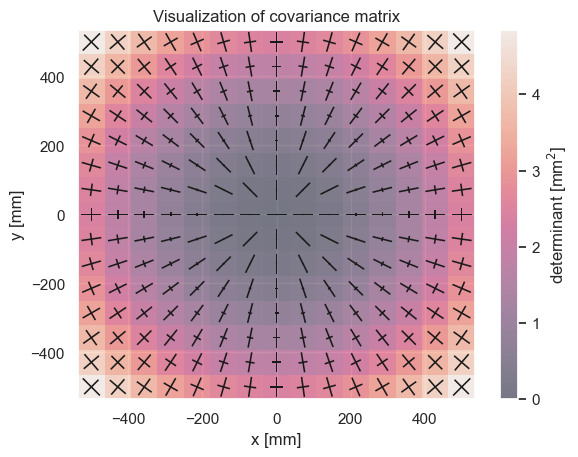

In [3]:
# plot a 1 square meter area
_x = np.linspace(-500,500, 15)
_y = np.linspace(-500,500, 15)

x, y = np.meshgrid(_x, _y)

# polar coordinates for further calculations
r = np.sqrt(x**2 + y**2)
phi = np.atan2(y, x)

r_cov = 2 # mm
phi_cov = np.deg2rad(1/3600) # 1''

# compute covariances via formula from previous cell
covariance_lambda = sympy.lambdify([k11, k22, r_sym, phi_sym], formula)
covariances = covariance_lambda(r_cov, phi_cov,r,phi)

#we need to rotate the axis beacause np.linalg expects a shape (...,m,n)
covariances = np.moveaxis(covariances, [0,1], [2,3])

plt.figure()
plt.title('Visualization of covariance matrix')
nmp_util.matrix_quiver(x, y, covariances, shade_determinant=True)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.show()

In [ ]:
campPP_df = nmp_util.read_dat('campPP_mar2024.dat', names = ['angle [°]', 'r [mm]']).astype(float)

xy_vals is an array of 2x1 column vectors (2, 1, 38)


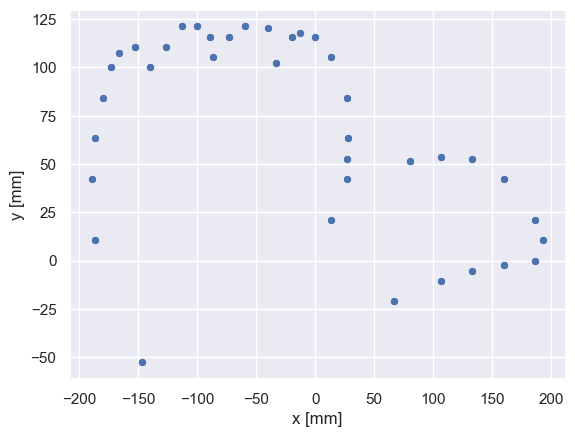

In [9]:
f_lambda = sympy.lambdify([phi_sym, r_sym],f_expr)
xy_vals = f_lambda(np.deg2rad(campPP_df['angle [°]']), campPP_df['r [mm]'])
print(f'xy_vals is an array of 2x1 column vectors {xy_vals.shape}')
campPP_df['x [mm]'] = xy_vals[0,0,:]
campPP_df['y [mm]'] = xy_vals[1,0,:]
sns.scatterplot(campPP_df, x = 'x [mm]', y = 'y [mm]')
plt.show()

# Create covariance matrix as $2n \times 2n$ matix

(2, 2, 38)


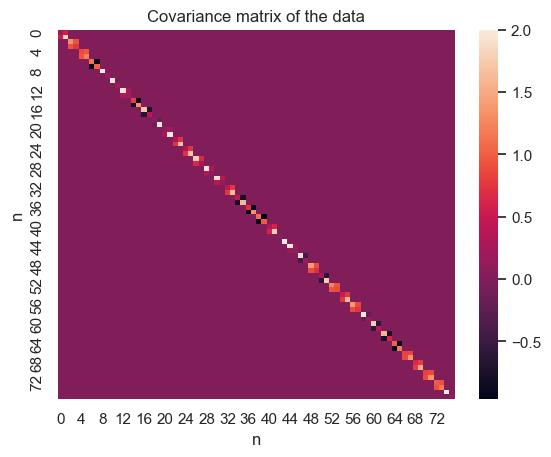

In [ ]:
from scipy.linalg import block_diag

covariances  : np.ndarray = covariance_lambda(r_cov, phi_cov, campPP_df['r [mm]'], campPP_df['angle [°]'])

print(covariances.shape)
covariance_matrix = block_diag(*covariances.swapaxes(2,0))

plt.title('Covariance matrix of the data')
sns.heatmap(covariance_matrix)
plt.xlabel('n')
plt.ylabel('n')
plt.show()